# Анализ и обработка данных одного куста

## Импорт библиотек

In [1]:
#from scipy.signal import savgol_filter
#import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from IPython.display import display
from pandas.plotting import autocorrelation_plot
from matplotlib import ticker

import sys
sys.path.append('custom_modules')

import Data_processing as dp
import Data_visualization as dv

## Константы 

In [2]:
# путь к файлу Excel
path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 201\Скважина 2011.xlsx'
#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 202\Скважина 2022.xlsx'

## Описание принципа обработки данных

В рамках подготовки данных было решено сделать следующие вычисления:
1. Удалить пропуски в данных (стоки датафрейма/таблицы где отсутствует хотя бы 1 значение)
2. Удалить строки датафрейма/таблицы где хотя бы у одного элемента значение равняется 0, так как такие значения классифицируются как отсутствие сигнала от прибора из-за того, что о выключен
3. Удалить выбросов в данных.
4. Удалить шумы из данных (предположительно белый шум)

Для удаления выбросов был выбран метод IQR

(Википедия, англ) The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
<a>https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba<\>


(Перевод) Межквартильный размах, также называемый межквартильным диапозоном или средним от 50% (формально H-распространение)в статистике - это мера дисперсии, равная разнице между 75% и 25% процентилями, или между нижним и верхним квартилем. Формула для расчета через квартили - IQR = Q3 - Q1.
    
Другими словами IQR - это разность 3 и 1 квартилей, а значения самих квартилей можно увидеть на диаграмме ящика с усами для исследуемых данных.
    
Эта мера идентична стандартному отклонению переменной, однако намного устойчивее к выбросам.

Идея метода - определение правой и левой границ ряда чисел между которыми находятся наиболее вероятные/часто встречаемые числа, а за их пределами числа, встречающиеся реже. Таким образом числа не входящие в диапазон считаются выбросами и удаляются или обрабатываются соответствующим образом.

В данной реализации первый квартиль расчитывался для 2,5%, а третий для 97,5%. Значения выбраны эмпирически. Значения границ высчитывались по формулам:
    
Q1-1.5*IQR - для левой границы;
    
Q3+1.5*IQR - для правой границы.
    
Формулы взяты из статьи выше.

# Исследование данных до обработки

In [3]:
def draw_4_frewuencis_graphs(df: pd.DataFrame):
    """Рисует 4 графика частоты встречающихся значений для каждого значащего столбца датафрейма.

    :param df: arg1
    :type df: DataFrame
    """
    columns = list(df.columns[1:])
    colors = ['b', 'm', 'g', 'r']
    
    fig, ax = plt.subplots(2,2)

    fig.set_figwidth(18)
    fig.set_figheight(14)
    
    colIter = iter(colors)
    
    ax = np.reshape(ax,(4,))
    
    itr = iter(ax)
    
    for col in columns:
        item = next(itr)
        n, bins, patches = item.hist(df[col], density=True, bins=100,
                                     stacked=False, alpha=.7, color=next(colIter))

        item.set_xlabel('Границы диапазонов (нормировано)', fontsize=15)
        item.set_ylabel('Количество встреч в выборке', fontsize=15)
        item.set_title(col, fontsize=20)

        #  Устанавливаем интервал основных делений:
        item.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        item.yaxis.set_major_locator(ticker.MultipleLocator(math.ceil(max(n) / 10)))

        #  Устанавливаем форматирование чисел основных делений:
        item.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        item.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

        #  Устанавливаем форматирование делений:
        item.xaxis.set_tick_params(which = 'major', labelsize = 15) #, labelrotation = 45)
        item.yaxis.set_tick_params(which = 'major', labelsize = 15)

        # Вывод и настройка сетки
        item.minorticks_on()
        item.grid(which='major', color = 'k', alpha = 0.6)
        item.grid(which='minor', color = 'gray', linestyle = ':')
        
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
    plt.show()

In [4]:
# чтение данных и приведение столбцов к нужным типам данных
first_df = dp.get_df(path_to_data)

In [5]:
# Общее описание данных до подготовки
#dv.describe_data(first_df)

Размер датасета:
до обработки:  (9361, 5) 
после:  (9292, 5) 
удалено строк:  69
100.00000000000001
100.00000000000004
100.00000000000004
100.00000000000001


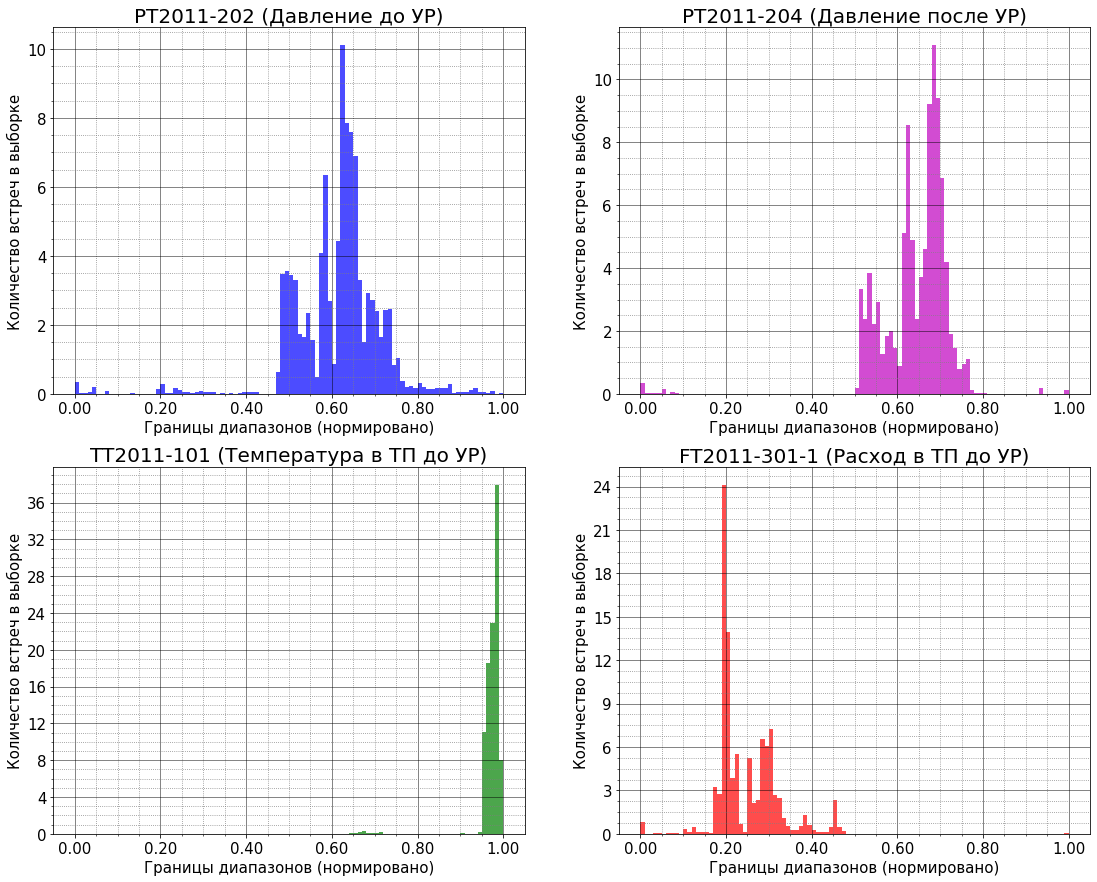

In [6]:
# Частота встречающихся значений для данных до подготовки
#dv.draw_4_frewuencis_graphs(first_df)
draw_4_frewuencis_graphs(dp.normalize_data(dp.delete_NANs(first_df)))

In [7]:
# вывести 4 графика автокорреляции (по графику на столбец) для необработанных данных
# тут у датафрейма все-равно удаляются NAN значения, ибо с ними этот график не рисуется
#dv.draw_4_autocorrelation_graphs(dp.delete_NANs(first_df))

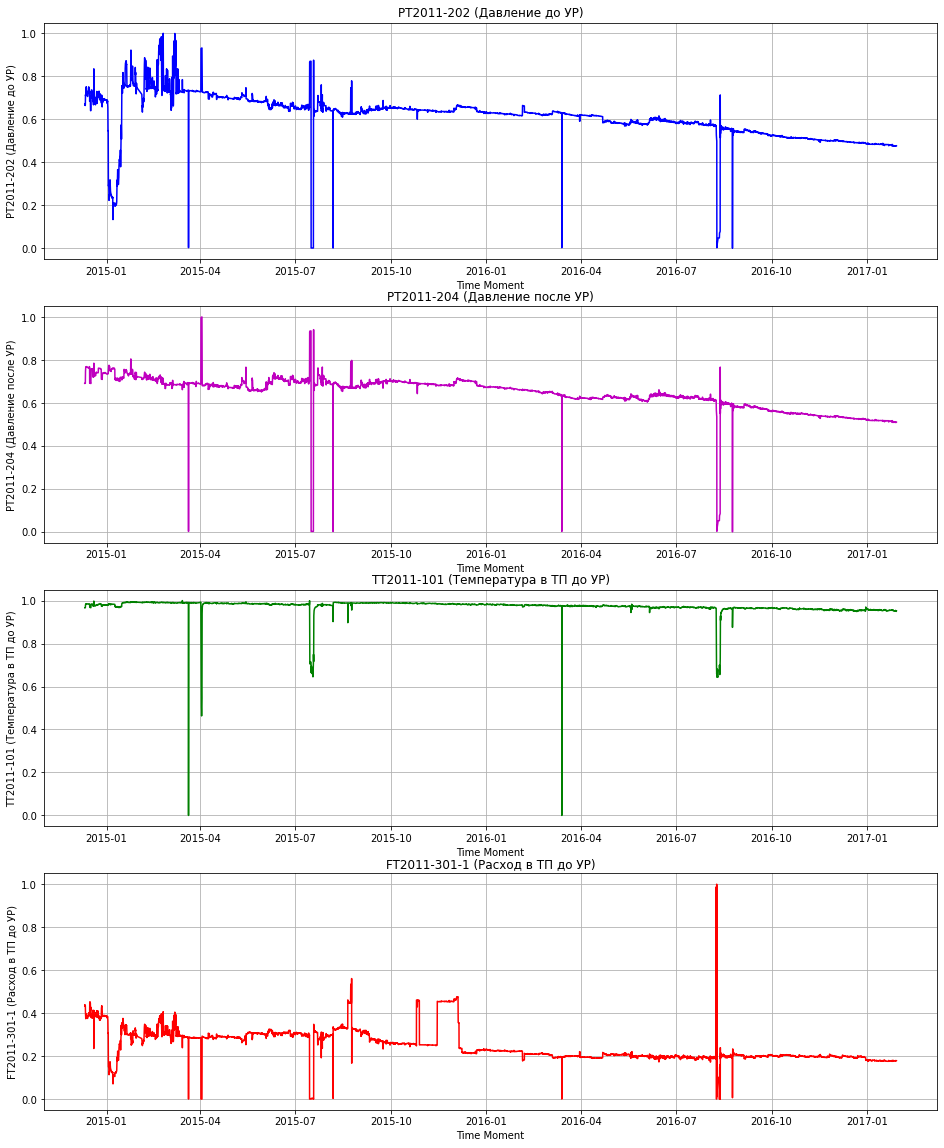

In [8]:
# визуализация данных до подготовки
dv.draw_4_graphs(first_df)

In [9]:
# вывод графиков отношений столбцов датафрейма без повторений для не подготовленных данных 
#dv.draw_6_relations_graphs(first_df)

# Обработка данных

In [10]:
# Удаление нулевых значений
prepared_df = dp.delete_zeros(first_df)

Размер датасета:
до обработки:  (9292, 5) 
после:  (9279, 5) 
удалено строк:  13


In [11]:
# Удаление пропусков данных
prepared_df = dp.delete_NANs(prepared_df)

Размер датасета:
до обработки:  (9279, 5) 
после:  (9279, 5) 
удалено строк:  0


In [12]:
# Удаление выбросов
prepared_df = dp.delete_outliers(prepared_df, soft_mode = False)


	Фильтрация по:  PT2011-202 (Давление до УР)
	Удалено строк:  435 


	Фильтрация по:  PT2011-204 (Давление после УР)
	Удалено строк:  0 


	Фильтрация по:  TT2011-101 (Температура в ТП до УР)
	Удалено строк:  18 


	Фильтрация по:  FT2011-301-1 (Расход в ТП до УР)
	Удалено строк:  331 

Размер датасета:
до обработки:  (9279, 5) 
после:  (8495, 5) 
удалено строк:  784


## Исследование данных после обработки

In [13]:
# Общее описание данных до подготовки
#dv.describe_data(prepared_df)

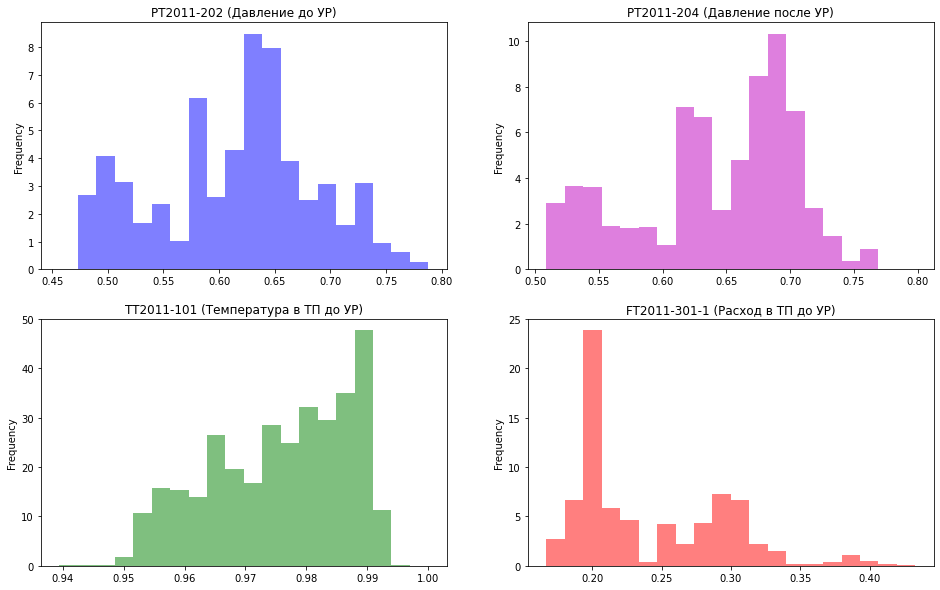

In [14]:
# Частота встречающихся значений для подготовленых данных
dv.draw_4_frewuencis_graphs(prepared_df)

In [15]:
# вывести 4 графика автокорреляции (по графику на столбец) для обработанных данных
#dv.draw_4_autocorrelation_graphs(prepared_df)

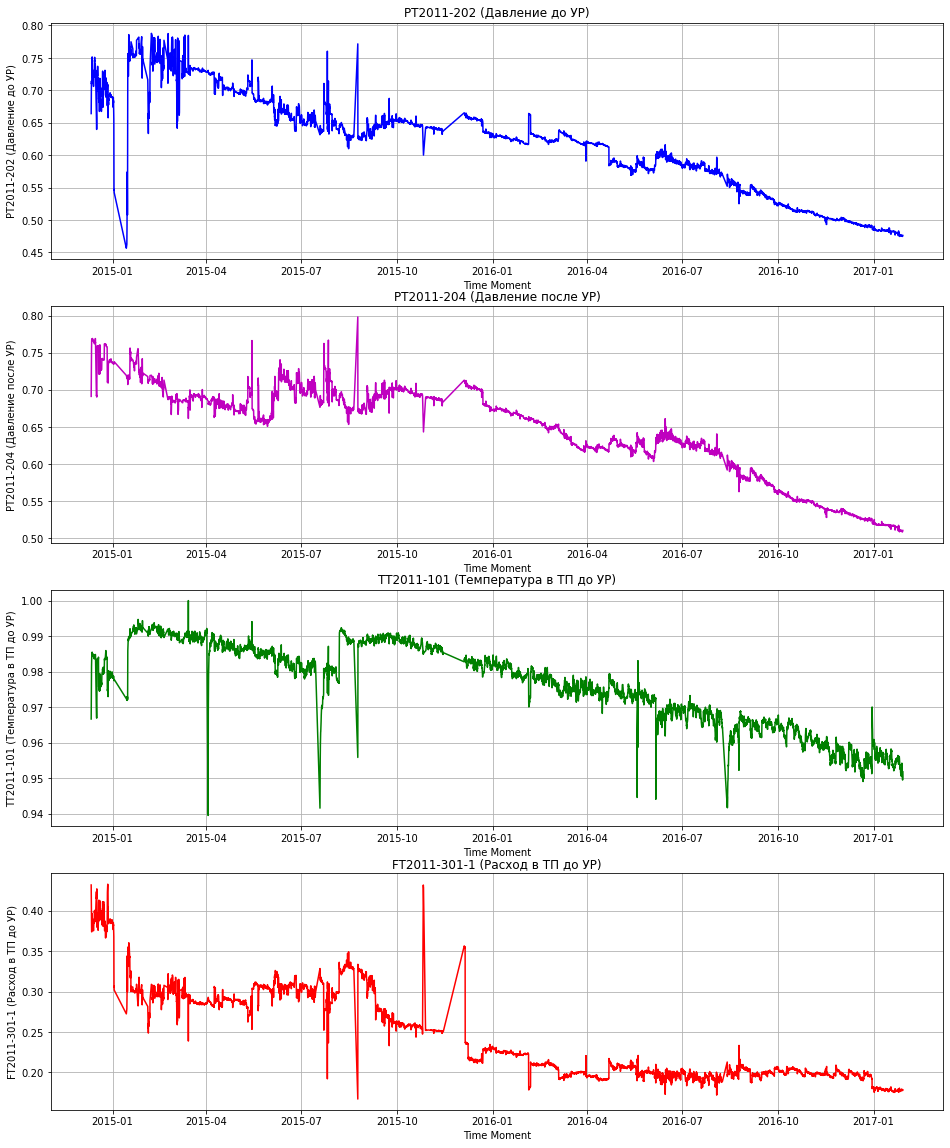

In [16]:
# визуализация данных после подготовки
dv.draw_4_graphs(prepared_df)

In [17]:
# вывод графиков отношений столбцов датафрейма без повторений для подготовленных данных
#dv.draw_6_relations_graphs(prepared_df)

# Наглядное сравнение обработанных данных с начальными

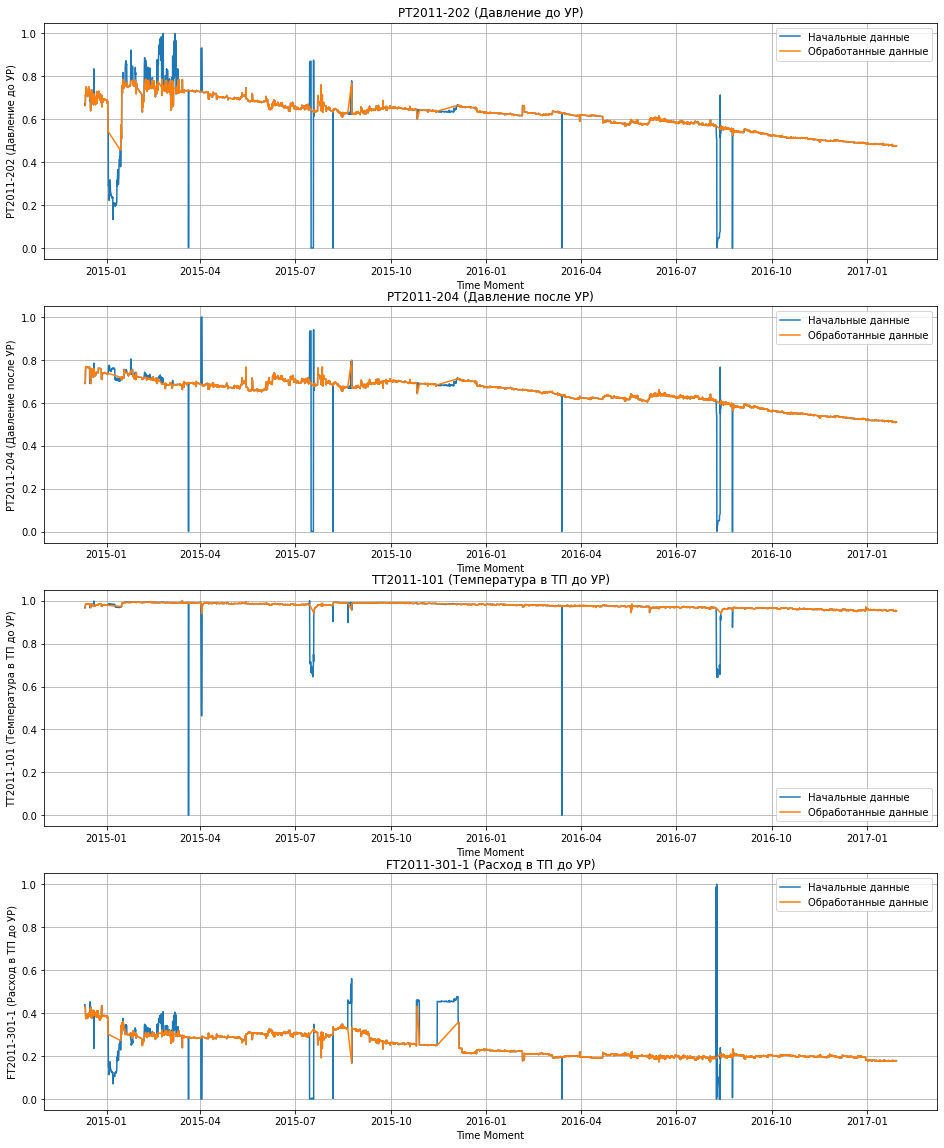

In [18]:
# вывод графиков для сравнения подготовленных данных и начальных (данные относительно времени по столбцам)
dv.draw_4_graphs_with_overlay_for_2_df(first_df, prepared_df)

# Выводы

Основной вывод - пригодность данных к использованию в обучении после обработки возросла.

Смотрим на матрицу коэффициентов корреляции данных, видим, что

а) корреляция между всеми столбцами имеется

б) после обработки большинство коэффициентов выросли (скорее всего из-за уменьшения кол-ва выбросов)

(однако расчета доверительных интервалов для этих коэффов и выводов о их стат. значимости сделано не было).

Смотрим на гистограммы частот встречающихся значений, видим, что до обработки в данных были крайне редко встречающиеся значения, портящие общую картину (выбросы). Тот же график температуры - это 2 столба, один мелкий - выбросы, другой большой - все нормольные значения. После обработки (удаления редких значений считай) гистограммы стали выглядеть лучше, даже нормальное распределение напоминают.

Смотрим на коррелограммы, видим, что графики до обработки держатся довольно близко к нулю (а чем ближе к нулю, тем случайнее данные, как я понял), та же температура только редкими выбросами от нуля уходит. После обработки графики от этого нуля весомо отдалились (хотя мб такое поведение как раз выбросами и обусловлено ну или тем загадочным белым шумом).

Смотрим на графики параметров относительно времени до и после, видим, что до обработки температура за краткий временной промежуток может измениться от 40 до -40, хотя по идее должна делать это куда дольше и плавнее (после обработки самый большой скачек - от 49 до 40). Да и вообще по графику и не скажешь общую тенденцию, ибо большая его часть - горизонтальная линия. В целом, то же самое можно и о других сказать. После обработки данные стали выглядеть лучше.

Есть еще кляксообразные графики зависимостей каждой переменной от каждой, но по ним мало что можно сказать, разве что то, что в них можно условно разглядеть графики, описывающие общую тенденцию, что намекает на то, что разработка нейросети для работы с этими данными не совсем имеет смысл (кстати после обработки в графиках проще разглядеть тенденции).